In [1]:
import sys
sys.path.append("/raid/project_drive/CV/ocr/kientdt/PaddleOCR2Pytorch")


In [64]:
from program import *
from pytorchocr.data import build_dataloader, set_signal_handlers
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorchocr.postprocess import build_post_process
from pytorchocr.modeling.architectures import build_model
from pytorchocr.losses import build_loss
from pytorchocr.optimizer import build_optimizer
from pytorchocr.utils.utility import *


In [12]:
def set_seed(seed=1024):
    random.seed(seed)
    np.random.seed(seed)
def preprocess(is_train=False):
    FLAGS = {
    'profiler_options': None,
    'config': "/raid/kientdt/shared_drive_cv/ocr/kientdt/PaddleOCR/configs/det/ch_PP-OCRv3/vi_PP-OCRv3_det_student_data_v1.yml",
    'opt': {'Global.use_gpu': True, 'Global.epoch_num': 100}
}

    profiler_options = FLAGS.get('profiler_options', None)
    config = load_config(FLAGS['config'])
    config = merge_config(config, FLAGS['opt'])
    profile_dic = {"profiler_options": FLAGS['profiler_options']}
    config = merge_config(config, profile_dic)

    if is_train:
        # save_config
        save_model_dir = config["Global"]["save_model_dir"]
        os.makedirs(save_model_dir, exist_ok=True)
        with open(os.path.join(save_model_dir, "config.yml"), "w") as f:
            yaml.dump(dict(config), f, default_flow_style=False, sort_keys=False)
        log_file = "{}/train.log".format(save_model_dir)
    else:
        log_file = None
    use_gpu = config['Global']['use_gpu']
    alg = config["Architecture"]["algorithm"]
    device = "cuda:2" if use_gpu else "cpu"
    check_device(use_gpu)

    # device = torch.cuda.set_device(device)



    return config, device

In [13]:
config, device = preprocess(is_train = True)
device

'cuda:2'

In [14]:
global_config = config["Global"]
set_signal_handlers()
seed = config["Global"]["seed"] if "seed" in config["Global"] else 1024
set_seed(seed)
train_dataloader = build_dataloader(config, "Train", device, seed)
if config["Eval"]:
    valid_dataloader = build_dataloader(config, "Eval", device, seed)


In [17]:
for batch in train_dataloader:
    break

In [8]:
# plt.imshow(batch[0][35].numpy().transpose(1, 2, 0))

In [15]:
step_pre_epoch = len(train_dataloader)
post_process_class = build_post_process(config["PostProcess"], global_config)


In [16]:
model = build_model(config["Architecture"])
loss_class = build_loss(config["Loss"])
optimizer, lr_scheduler = build_optimizer(
        config["Optimizer"],
        epochs=config["Global"]["epoch_num"],
        step_each_epoch=len(train_dataloader),
        model=model,
    )

In [17]:
# for idx, batch in enumerate(train_dataloader):
#     model.train()
#     preds = model(batch[0])
#     preds = to_float32(preds)
#     loss = loss_class(preds, batch)
#     avg_loss = loss["loss"]
#     avg_loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#     if not isinstance(lr_scheduler, float):
#         lr_scheduler.step()
from tqdm import tqdm

# Assuming train_dataloader is a DataLoader object
for idx, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Training Progress"):
    model.to(device)
    batch = [item.to(device) for item in batch]  
    model.train()
    preds = model(batch[0])
    preds = to_float32(preds)
    
    loss = loss_class(preds, batch)
    avg_loss = loss["loss"]
    
    avg_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if not isinstance(lr_scheduler, float):
        lr_scheduler.step()


Training Progress: 100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


In [38]:
model.eval()
with torch.no_grad():
    for idx, batch in enumerate(valid_dataloader):
        batch = [item.to(device) for item in batch]  
        preds = model(batch[0])
        batch_numpy = []
        for item in batch:
            if isinstance(item, torch.Tensor):
                batch_numpy.append(item.cpu().numpy())
            else:
                batch_numpy.append(item)
        post_result = post_process_class(preds, batch_numpy[1])
        break
        

In [28]:
post_result

[{'points': array([[[   0,    0],
          [1308,    0],
          [1308,   92],
          [   0,   92]]], dtype=int16)}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


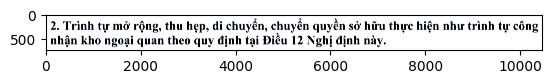

In [52]:
plt.imshow(batch[0][0].cpu().numpy().transpose(1, 2, 0))
img = batch[0][0].cpu().numpy().transpose(1, 2, 0)

In [59]:
for point in post_result[0]['points']:
    pts = np.array(point, dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
        
        # Draw the bounding box on the image
    img = cv2.polylines(img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)
plt.imshow(img)

error: OpenCV(4.11.0-pre) :-1: error: (-5:Bad argument) in function 'polylines'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


In [61]:
pts

array([[[419,  60]],

       [[421,  60]],

       [[421,  61]],

       [[419,  61]]], dtype=int32)

In [32]:
state_dict = torch.load("/raid/project_drive/CV/ocr/kientdt/PaddleOCR2Pytorch/ch_ptocr_v3_det_infer_student.pth")

In [37]:
model.load_state_dict(state_dict)

<All keys matched successfully>